In [1]:
import sys
sys.path.insert(0,'ladybug')
sys.path.insert(0,'honeybee')

In [2]:
import ladybug
#help(ladybug)

In [3]:
import honeybee
#help(honeybee)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import json
import re
import os

from honeybee.radiance.recipe.daylightfactor.gridbased import GridBased as df_GridBased
from honeybee.radiance.recipe.annual.gridbased import GridBased as annual_GridBased
from honeybee.radiance.sky.skymatrix import SkyMatrix
from honeybee.room import Room
from honeybee.radiance.material.glass import Glass
from honeybee.radiance.analysisgrid import AnalysisGrid
from honeybee.futil import bat_to_sh

Path to radiance is set to: c:/radiance


Found 6 opaque surfaces.
Found 4 fenestration surfaces.
Found 0 window-groups.
Found 6 opaque surfaces.
Found 4 fenestration surfaces.
Found 0 window-groups.
Found 6 opaque surfaces.
Found 4 fenestration surfaces.
Found 0 window-groups.
Found 6 opaque surfaces.
Found 4 fenestration surfaces.
Found 0 window-groups.
Writing recipe contents to: room\daylightfactor\daylightfactor
Writing recipe contents to: room\annual\gridbased_annual
Calculating solar values...
Reusing sun_matrix: sunmtx_vis_037760_51.15_-0.18_0.0.mtx.
Unloading the current values from the analysis grids.


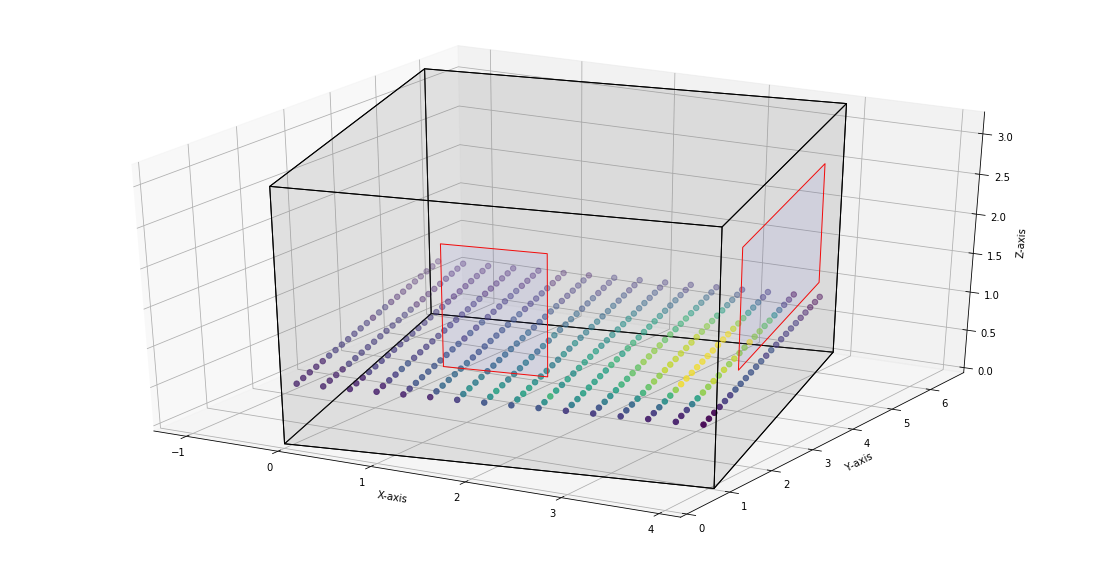

In [11]:
room = Room(origin=(0, 0, 0), width=4.2, depth=6, height=3.2, rotation_angle=12)
room.add_fenestration_surface('back', 1, 1.5, 1.2, radiance_material=Glass.by_single_trans_value('tvis_0.45', 0.45))
room.add_fenestration_surface('right', 4, 1.5, 1.2, radiance_material=Glass.by_single_trans_value('tvis_0.6', 0.6))

test_points = room.generate_test_points(grid_size=0.25, height=0.75)
test_grid = AnalysisGrid.from_points_and_vectors(test_points, name="test_room")

# Get all the room surface vertex locations
xs, ys, zs = list(zip(*[element for tupl in [point.points[0] for point in room.surfaces] for element in tupl]))

# create the daylight factor recipe (without geometry)
df_recipe = df_GridBased(analysis_grids=(test_grid,), hb_objects=(room,))

# generate a sky matrix from a weatherfile
weatherfile = "weather/GBR_London.Gatwick_IWEC.epw"
sky_matrix = SkyMatrix.from_epw_file(weatherfile, sky_density=2, north=0, hoys=range(0, 8760), mode=0, suffix="")

# create the annual daylight recipe (without geometry)
annual_recipe = annual_GridBased(sky_matrix, analysis_grids=(test_grid,), hb_objects=(room,)) # <<<<<< add modified raytrace parametrs

# append contextual geometry to the created daylight factor recipe
df_recipe.hb_objects = room.surfaces

# append contextual geometry to the created annual recipe
annual_recipe.hb_objects = room.surfaces

# Generate bat file for daylight factor
df_bat = df_recipe.write("room", "daylightfactor")

# Generate bat file for daylight factor
annual_bat = annual_recipe.write("room", "annual")

# run the daylight factor analysis
df_recipe.run(df_bat, True)

# run the annual daylight analysis
annual_recipe.run(annual_bat, True)

# GET THE ANNUAL DAYLIGHT METRICS HERE!!!

# need to figure out how to get the results coupled to the daylight factor run - this method is a kludge for the time being
df_results = [r.to_json() for r in df_recipe.results()]
with open ("C:/Users/tgerrish/Desktop/ladybug-tools-TG/room/daylightfactor/daylightfactor/result/results.json", "w") as results_file:
    results_file.write(json.dumps(df_results))
    results_file.close()
df_results_list = [point["values"][0][0][6324][0] for point in df_results[0]["analysis_points"]]

# generate plot
fig = plt.figure(figsize=(15, 7.5))
ax = Axes3D(fig)
# set ax lims
ax.set_xlim([np.min(xs), np.max(xs)])
ax.set_ylim([np.min(ys), np.max(ys)])
ax.set_zlim([np.min(zs), np.max(zs)])
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
# plot surfaces
for surface in room.surfaces:
    ax.add_collection3d(Poly3DCollection(surface.points, facecolor=(0.5, 0.5, 0.5, 0.1), edgecolor="k", linewidth=1, zorder=-1))
# plot windows
for children in room.children_surfaces:
    for child in children.points:
        ax.add_collection3d(Poly3DCollection([child], facecolor=(0, 0, 1, 0.05), edgecolor="r", linewidth=1, zorder=-1))
# plot the analysis points
ax.scatter([i.x for i in test_grid.points], [i.y for i in test_grid.points], [i.z for i in test_grid.points], c=df_results_list, cmap="viridis", s=30, marker="o")

In [10]:
annual_recipe.results()[0].annual_metrics()

Unloading the current values from the analysis grids.

Adding room\annual\gridbased_annual\room\annual\gridbased_annual\result/scene..default.ill to result files for test_room

Loading the results from result files.


WindowsError: [Error 3] The system cannot find the path specified: 'room\\annual\\gridbased_annual\\room\\annual\\gridbased_annual\\result/scene..default.ill'

In [ ]:
%matplotlib inline
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json
import os
from honeybee.room import Room
from honeybee.radiance.material.glass import Glass
from honeybee.radiance.sky.certainIlluminance import CertainIlluminanceLevel
from honeybee.radiance.parameters.rtrace import RtraceParameters
from honeybee.radiance.sky.skymatrix import SkyMatrix
from honeybee.radiance.recipe.annual.gridbased import GridBased
from honeybee.radiance.analysisgrid import AnalysisGrid
from honeybee.futil import bat_to_sh
from honeybee.schedule import Schedule

# create a test room
room = Room(origin=(0, 0, 0), width=4.2, depth=6, height=3.2, rotation_angle=45)

# add fenestrations

# add a window to the back wall
room.add_fenestration_surface(wall_name='back', width=2, height=2, sill_height=0.7)

# add a window with custom material to the right wall
glass_60 = Glass.by_single_trans_value('tvis_0.6', 0.6)
room.add_fenestration_surface('right', 4, 1.5, 1.2, radiance_material=glass_60)

# generate grid of test points
test_points = room.generate_test_points(grid_size=0.5, height=0.75)
test_grid = AnalysisGrid.from_points_and_vectors(test_points, name="Test room")

# Get all the vertex locations
xs, ys, zs = list(zip(*[element for tupl in [point.points[0] for point in room.surfaces] for element in tupl]))
# generate plot
fig = plt.figure(figsize=(10, 5))
ax = Axes3D(fig)
# set ax lims
ax.set_xlim([np.min(xs), np.max(xs)])
ax.set_ylim([np.min(ys), np.max(ys)])
ax.set_zlim([np.min(zs), np.max(zs)])
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
# plot surfaces
for surface in room.surfaces:
    ax.add_collection3d(Poly3DCollection(surface.points, facecolor=(0.5, 0.5, 0.5, 0.1), edgecolor="k", linewidth=1, zorder=-1))
# plot windows
for children in room.children_surfaces:
    for child in children.points:
        ax.add_collection3d(Poly3DCollection([child], facecolor=(0, 0, 1, 0.05), edgecolor="r", linewidth=1, zorder=-1))
# plot the analysis points
ax.scatter([i.x for i in test_grid.points], [i.y for i in test_grid.points], [i.z for i in test_grid.points], c="k", s=10, marker="o")

# generate a sky matrix from a weatherfile
weatherfile = "weather/GBR_London.Gatwick_IWEC.epw"
sky = SkyMatrix.from_epw_file(weatherfile, sky_density=2, north=0, hoys=range(0, 8760), mode=0, suffix="")

# put the recipe together
recipe = GridBased(sky_mtx=sky, analysis_grids=(test_grid,), simulation_type=0, hb_objects=(room,))
recipe_json = recipe.to_json()
# save as a json file
with open("room/recipe.json", "w") as f:
    json.dump(recipe_json, f)

